<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Converting Llama 2 to Llama 3.2 From Scratch

- This is a follow-up notebook to [Converting a From-Scratch GPT Architecture to Llama 2](./converting-gpt-to-llama2.ipynb), converting Meta AI's Llama 2 architecture model step by step to Llama 3, Llama 3.1, and Llama 3.2
- The explanations are purposefully kept minimal in this notebook so as not to bloat it unnecessarily and focus on the main code
- For more information about the architectures, please see the Llama 2 and Llama 3 papers
 - [Llama 2: Open Foundation and Fine-Tuned Chat Models (2023)](https://arxiv.org/abs/2307.09288)
 - [The Llama 3 Herd of Models](https://arxiv.org/abs/2407.21783)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/gpt2-to-llama2-llama3.webp?1">

In [1]:
# pip install -r requirements-extra.txt

- Packages that are being used in this notebook:

In [2]:
from importlib.metadata import version

pkgs = [
    "blobfile",         # to download pretrained weights
    "huggingface_hub",  # to download pretrained weights
    "matplotlib",       # to visualize RoPE with different base frequencies
    "tiktoken",         # to implement the tokenizer
    "torch",            # to implement the model
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

blobfile version: 3.1.0
huggingface_hub version: 0.34.4
tiktoken version: 0.11.0
torch version: 2.8.0


&nbsp;
# 1. Convert the Llama model implementation step by step

- If you are new to implementing LLM architectures, I recommend starting with [chapter 4](../../ch04/01_main-chapter-code/ch04.ipynb), which walks you through the implementation of the original GPT architecture step by step
- The [Converting a From-Scratch GPT Architecture to Llama 2](./converting-gpt-to-llama2.ipynb) then implements the Llama-specific components, such as RMSNorm layers, SiLU and SwiGLU activations, RoPE (rotary position embeddings), and the SentencePiece tokenizer
- This notebook takes the Llama 2 architecture and transforms it into Llama 3 architecture by
    1. modifying the rotary embeddings
    2. implementing grouped-query attention
    3. and using a customized version of the GPT-4 tokenizer
- Later, we then load the original Llama 3 weights shared by Meta AI into the architecture

&nbsp;
## 1.1 Reusing Llama 2 components

- Llama 2 is actually quite similar to Llama 3, as mentioned above and illustrated in the figure at the top of this notebook
- This means that we can import several building blocks from the [Llama 2 notebook](./converting-gpt-to-llama2.ipynb) using the following code

In [3]:
import os
import sys
import io
import nbformat
import types

def import_from_notebook():
    def import_definitions_from_notebook(fullname, names):
        current_dir = os.getcwd()
        path = os.path.join(current_dir, fullname + ".ipynb")
        path = os.path.normpath(path)

        # Load the notebook
        if not os.path.exists(path):
            raise FileNotFoundError(f"Notebook file not found at: {path}")

        with io.open(path, "r", encoding="utf-8") as f:
            nb = nbformat.read(f, as_version=4)

        # Create a module to store the imported functions and classes
        mod = types.ModuleType(fullname)
        sys.modules[fullname] = mod

        # Go through the notebook cells and only execute function or class definitions
        for cell in nb.cells:
            if cell.cell_type == "code":
                cell_code = cell.source
                for name in names:
                    # Check for function or class definitions
                    if f"def {name}" in cell_code or f"class {name}" in cell_code:
                        exec(cell_code, mod.__dict__)
        return mod

    fullname = "converting-gpt-to-llama2"
    names = ["precompute_rope_params", "compute_rope", "SiLU", "FeedForward", "RMSNorm", "MultiHeadAttention"]

    return import_definitions_from_notebook(fullname, names)

In [4]:
imported_module = import_from_notebook()

# We need to redefine precompute_rope_params
# precompute_rope_params = getattr(imported_module, "precompute_rope_params", None)
compute_rope = getattr(imported_module, "compute_rope", None)
SiLU = getattr(imported_module, "SiLU", None)
FeedForward = getattr(imported_module, "FeedForward", None)
RMSNorm = getattr(imported_module, "RMSNorm", None)

# MultiHeadAttention only for comparison purposes
MultiHeadAttention = getattr(imported_module, "MultiHeadAttention", None)

&nbsp;
## 1.2 Modified RoPE

- Llama 3 uses rotary position embeddings (RoPE) similar to Llama 2 (for a detailed explanation, please see the [RoPE paper](https://arxiv.org/abs/2104.09864))
- There are some subtle differences in the RoPE settings, though
 - Llama 3 now supports up to 8,192 tokens, twice as many as Llama 2 (4,096)
 - The base value for the so-called RoPE $\theta$ (see equation below) was increased from 10,000 (Llama 2) to 500,000 (Llama 3) in the following equation (adapted from the [RoPE paper](https://arxiv.org/abs/2104.09864))

$$\Theta = \left\{\theta_i = \text{base}^{\frac{-2(i-1)}{d}}, i \in \left[1, 2, ..., d/2\right]\right\}$$

- These $\theta$ values are a set of predefined parameters that are used to determine the rotational angles in the rotary matrix, where $d$ is the dimensionality of the embedding space
- Increasing the base from 10,000 to 500,000 makes the frequencies decay faster across the dimensions, which means that the higher-dimensional components are associated with smaller rotation angles than before, so the overall frequency range becomes more compressed rather than expanded

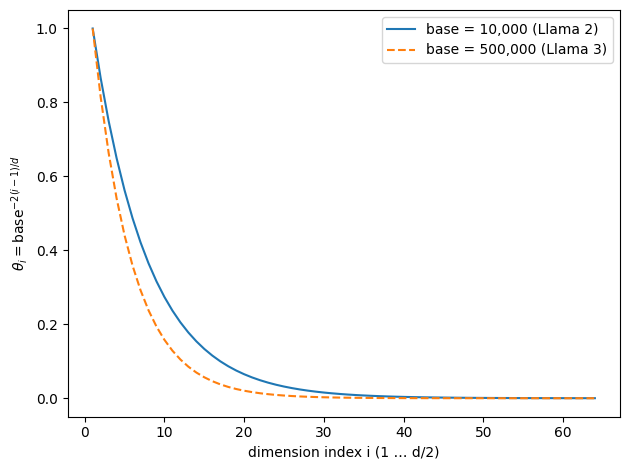

In [1]:
import matplotlib.pyplot as plt
import torch

d = 128
i = torch.arange(1, d // 2 + 1)

base_llama2 = 10_000
base_llama3 = 500_000

theta_llama2 = base_llama2 ** (-2 * (i - 1) / d)
theta_llama3 = base_llama3 ** (-2 * (i - 1) / d)

plt.plot(i, theta_llama2, label="base = 10,000 (Llama 2)")
plt.plot(i, theta_llama3, label="base = 500,000 (Llama 3)", ls="--")
plt.xlabel("dimension index i (1 … d/2)")
plt.ylabel(r"$\theta_i = \mathrm{base}^{-2(i-1)/d}$")
plt.legend()
plt.tight_layout()

- This changed decay rate is to better support longer context lengths without the rotations becoming too much or too strong at higher dimensions (larger positions)
- In addition, we introduce a `freq_config` section in the code below that adjusts the frequency; however, we won't be needing it in Llama 3 (only Llama 3.1 and Llama 3.2), so we will revisit this `freq_config` later (it's set to `None` and ignored by default)

In [5]:
import torch

def precompute_rope_params(head_dim, theta_base=10_000, context_length=4096, freq_config=None):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    # Compute the inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2)[: (head_dim // 2)].float() / head_dim))

    ################################ NEW ###############################################
    # Frequency adjustments
    if freq_config is not None:
        low_freq_wavelen = freq_config["original_context_length"] / freq_config["low_freq_factor"]
        high_freq_wavelen = freq_config["original_context_length"] / freq_config["high_freq_factor"]

        wavelen = 2 * torch.pi / inv_freq

        inv_freq_llama = torch.where(
            wavelen > low_freq_wavelen, inv_freq / freq_config["factor"], inv_freq
        )

        smooth_factor = (freq_config["original_context_length"] / wavelen - freq_config["low_freq_factor"]) / (
            freq_config["high_freq_factor"] - freq_config["low_freq_factor"]
        )

        smoothed_inv_freq = (
            (1 - smooth_factor) * (inv_freq / freq_config["factor"]) + smooth_factor * inv_freq
        )

        is_medium_freq = (wavelen <= low_freq_wavelen) & (wavelen >= high_freq_wavelen)
        inv_freq_llama = torch.where(is_medium_freq, smoothed_inv_freq, inv_freq_llama)
        inv_freq = inv_freq_llama
    ####################################################################################


    # Generate position indices
    positions = torch.arange(context_length)

    # Compute the angles
    angles = positions.unsqueeze(1) * inv_freq.unsqueeze(0)  # Shape: (context_length, head_dim // 2)

    # Expand angles to match the head_dim
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)

    # Precompute sine and cosine
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin

- To summarize, what's new so far for Llama 3 compared to Llama 2 are the context length and theta base parameter:

In [6]:
# Instantiate RoPE parameters

llama_2_context_len = 4096
llama_3_context_len = 8192

llama_2_theta_base = 10_000
llama_3_theta_base = 500_000

- The usage remains the same as before in Llama 2:

In [7]:
# Settings
batch_size = 2
num_heads = 4
head_dim = 16

# Instantiate RoPE parameters
cos, sin = precompute_rope_params(
    head_dim=head_dim,
    theta_base=llama_3_theta_base,
    context_length=llama_3_context_len
)

# Dummy query and key tensors
torch.manual_seed(123)
queries = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)
keys = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)

# Apply rotary position embeddings
queries_rot = compute_rope(queries, cos, sin)
keys_rot = compute_rope(keys, cos, sin)

&nbsp;
## 1.3 Grouped-query attention

- In this section, we replace multi-head attention (MHA) with an alternative mechanism called grouped-query attention (GQA)
- In short, one can think of GQA as a more compute- and parameter-efficient version of MHA
- In GQA, we reduce the number of key and value projections by sharing them among multiple attention heads
- Each attention head still has its unique query, but these queries attend to the same group of keys and values
- Below is an illustration of GQA with 2 key-value-groups (kv-groups):

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/grouped-query-attention.webp" width="500px">


- The main idea behind GQA is to reduce the number of unique query groups that attend to the key-value pairs, reducing the size of some of the matrix multiplications and the number of parameters in MHA without significantly reducing modeling performance
- The GQA code is very similar to MHA (I highlighted the changes below via the "NEW" sections)
- In short, the main change in GQA is that each query group needs to be repeated to match the number of heads it is associated with, as implemented below

- **We also redesign the attention class a bit so it receives the mask through its forward method instead of storing and accessing it as `self.mask`. This lets us build the mask on the fly to reduce memory usage. To foreshadow why: Llama 3.1 can handle sequences of up to 128 k tokens, and precomputing a 128 k × 128 k causal mask would be extremely memory‑intensive, so we avoid it unless absolutely necessary.**

In [8]:
import torch.nn as nn


class GroupedQueryAttention(nn.Module):
    def __init__(
            self, d_in, d_out, num_heads,
            num_kv_groups,       # NEW
            dtype=None
        ):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"  # NEW

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        ############################# NEW  #############################
        # self.W_key = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        # self.W_value = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups
        ################################################################

        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)


    def forward(self, x, mask=None, cos=None, sin=None):
        ##################### NEW  #####################
        # The forward method now accepts `mask` instead of accessing it via self.mask.
        # Also, we now have cos and sin as input for RoPE
        ################################################    
        b, num_tokens, d_in = x.shape

        queries = self.W_query(x)  # Shape: (b, num_tokens, d_out)
        keys = self.W_key(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)

        # Reshape queries, keys, and values
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        ##################### NEW  #####################
        # keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        # values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        ################################################

        # Transpose keys, values, and queries
        keys = keys.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        values = values.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        queries = queries.transpose(1, 2)  # Shape: (b, num_heads, num_tokens, head_dim)

        ##################### NEW #####################
        # Apply RoPE
        if cos is not None:
            keys = compute_rope(keys, cos, sin)
            queries = compute_rope(queries, cos, sin)
        ################################################

        ##################### NEW  #####################
        # Expand keys and values to match the number of heads
        # Shape: (b, num_heads, num_tokens, head_dim)

        keys = keys.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)
        values = values.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)
        # For example, before repeat_interleave along dim=1 (query groups):
        #   [K1, K2]
        # After repeat_interleave (each query group is repeated group_size times):
        #   [K1, K1, K2, K2]
        # If we used regular repeat instead of repeat_interleave, we'd get:
        #   [K1, K2, K1, K2]
        ################################################

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        # Shape: (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        ##################### NEW #####################
        # Create mask on the fly
        if mask is None:
            mask = torch.triu(torch.ones(num_tokens, num_tokens, device=x.device, dtype=torch.bool), diagonal=1)
        ################################################
    
        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        assert keys.shape[-1] == self.head_dim

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

- To illustrate the parameter savings in GQA over MHA, consider the following multi-head attention example from the GPT and Llama 2 code:

In [9]:
# Settings
batch_size = 1
context_len = 3000
max_context_len = 8192
embed_dim = 4096
num_heads = 32


example_batch = torch.randn((batch_size, context_len, embed_dim))

mha = MultiHeadAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads
)

mha(example_batch)

print("W_key:", mha.W_key.weight.shape)
print("W_value:", mha.W_value.weight.shape)
print("W_query:", mha.W_query.weight.shape)

W_key: torch.Size([4096, 4096])
W_value: torch.Size([4096, 4096])
W_query: torch.Size([4096, 4096])


- Now, if we use grouped-query attention instead, with 8 kv-groups (that's how many Llama 3 8B uses), we can see that the number of rows of the key and value matrices are reduced by a factor of 4 (because 32 attention heads divided by 8 kv-groups is 4)

In [10]:
gqa = GroupedQueryAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    num_heads=num_heads,
    num_kv_groups=8,
)

gqa(example_batch)

print("W_key:", gqa.W_key.weight.shape)
print("W_value:", gqa.W_value.weight.shape)
print("W_query:", gqa.W_query.weight.shape)

W_key: torch.Size([1024, 4096])
W_value: torch.Size([1024, 4096])
W_query: torch.Size([4096, 4096])


- As a side note, to make the GroupedQueryAttention equivalent to standard multi-head attention, you can set the number of query groups (`num_kv_groups`) equal to the number of heads (`num_heads`)
- Lastly, let's compare the number of parameters below:

In [11]:
print("Total number of parameters:")

mha_total_params = sum(p.numel() for p in mha.parameters())
print(f"MHA: {mha_total_params:,}")

gqa_total_params = sum(p.numel() for p in gqa.parameters())
print(f"GQA: {gqa_total_params:,}")

Total number of parameters:
MHA: 67,108,864
GQA: 41,943,040


In [12]:
# Free up memory:
del mha
del gqa

&nbsp;
## 1.4 Update the TransformerBlock module

- Next, we update the `TransformerBlock`
- Here, we simply swap `MultiHeadAttention` with `GroupedQueryAttention` and add the new RoPE settings
- In addition, we also modify the `forward` method so that it receives `mask`, `cos`, and `sin`; since the values for those are the same for each transformer block, we only have to compute them once and then can reuse them

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att =  GroupedQueryAttention(  # MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],  # NEW
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.norm2 = RMSNorm(cfg["emb_dim"], eps=1e-5)

    def forward(self, x, mask=None, cos=None, sin=None):
        ##################### NEW  #####################
        # The forward method now accepts `mask` instead of accessing it via self.mask.
        # Also, we now have cos and sin as input for RoPE
        ################################################
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16), mask, cos, sin)   # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut  # Add the original input back

        return x

&nbsp;
## 1.5 Defining the model class

- When setting up the model class, we technically don't have to do much; we just update the name to `Llama3Model`
- However, since we now pass the `mask`, `cos`, and `sin` to the transformer blocks, we also have to add them here

In [14]:
# class Llama2Model(nn.Module):
class Llama3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

        #################### NEW #####################
        cos, sin = precompute_rope_params(
            head_dim=cfg["emb_dim"] // cfg["n_heads"],
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"],
            freq_config=cfg["rope_freq"]
        )
        
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)
        ##############################################

        self.cfg = cfg

    def forward(self, in_idx):
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds

        #################### NEW #####################
        num_tokens = x.shape[1]
        mask = torch.triu(torch.ones(num_tokens, num_tokens, device=x.device, dtype=torch.bool), diagonal=1)
        ##############################################
        
        for block in self.trf_blocks:
            x = block(x, mask, self.cos, self.sin)
        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        return logits

&nbsp;
## 2. Initialize model

- Now we can define a Llama 3 config file (the Llama 2 config file is shown for comparison)

In [15]:
LLAMA2_CONFIG_7B = {
    "vocab_size": 32_000,    # Vocabulary size
    "context_length": 4096,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 11_008,    # Size of the intermediate dimension in FeedForward
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}

In [16]:
LLAMA3_CONFIG_8B = {
    "vocab_size": 128_256,   # NEW: Larger vocabulary size
    "context_length": 8192,  # NEW: Larger context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 14_336,    # NEW: Larger size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,        # NEW: Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,  # NEW: The base in RoPE's "theta" was increased to 500_000
    "rope_freq": None,       # NEW: Additional configuration for adjusting the RoPE frequencies
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}

- Using these settings, we can now initialize a Llama 3 8B model
- Note that this requires ~34 GB of memory (for comparison, Llama 2 7B required ~26 GB of memory)

In [17]:
model = Llama3Model(LLAMA3_CONFIG_8B)

- Let's now compute the number of trainable parameters:

In [18]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 8,030,261,248


- As shown above, the model contains 8 billion parameters
- Additionally, we can calculate the memory requirements for this model using the code below:

In [19]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 59.84 GB
bfloat16: 29.92 GB


- Lastly, we can also transfer the model to an NVIDIA or Apple Silicon GPU if applicable:

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device);

&nbsp;
## 3. Load tokenizer

- In this section, we are going to load the tokenizer for the model
- Llama 2 used Google's [SentencePiece](https://github.com/google/sentencepiece) tokenizer instead of OpenAI's BPE tokenizer based on the [Tiktoken](https://github.com/openai/tiktoken) library
- Llama 3, however, reverted back to using the BPE tokenizer from Tiktoken; specifically, it uses the GPT-4 tokenizer with an extended vocabulary
- You can find the original Tiktoken-adaptation by Meta AI [here](https://github.com/meta-llama/llama3/blob/main/llama/tokenizer.py) in their official Llama 3 repository
- Below, I rewrote the tokenizer code to make it more readable and minimal for this notebook (but the behavior should be similar)

In [21]:
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe


class Tokenizer:
    """Thin wrapper around tiktoken that keeps track of Llama-3 special IDs."""
    def __init__(self, model_path):
        if not os.path.isfile(model_path):
            raise FileNotFoundError(model_path)

        mergeable = load_tiktoken_bpe(model_path)

        # hard-coded from Meta's tokenizer.json
        self.special = {
            "<|begin_of_text|>": 128000,
            "<|end_of_text|>": 128001,
            "<|start_header_id|>": 128006,
            "<|end_header_id|>": 128007,
            "<|eot_id|>": 128009,
        }
        self.special.update({f"<|reserved_{i}|>": 128002 + i
                             for i in range(256)
                             if 128002 + i not in self.special.values()})

        self.model = tiktoken.Encoding(
            name=Path(model_path).name,
            pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)"
                    r"|[^\r\n\p{L}\p{N}]?\p{L}+"
                    r"|\p{N}{1,3}"
                    r"| ?[^\s\p{L}\p{N}]+[\r\n]*"
                    r"|\s*[\r\n]+"
                    r"|\s+(?!\S)"
                    r"|\s+",
            mergeable_ranks=mergeable,
            special_tokens=self.special,
        )

    def encode(self, text, bos=False, eos=False):
        ids = ([self.special["<|begin_of_text|>"]] if bos else []) \
              + self.model.encode(text)
        if eos:
            ids.append(self.special["<|end_of_text|>"])
        return ids

    def decode(self, ids):
        return self.model.decode(ids)

- Meta AI shared the original Llama 3 model weights and tokenizer vocabulary on the Hugging Face Hub
- We will first download the tokenizer vocabulary from the Hub and load it into the code above

- Please note that Meta AI requires that you accept the Llama 3 licensing terms before you can download the files; to do this, you have to create a Hugging Face Hub account and visit the [meta-llama/Meta-Llama-3-8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B) repository to accept the terms
- Next, you will need to create an access token; to generate an access token with READ permissions, click on the profile picture in the upper right and click on "Settings"


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/settings.webp?1" width="300px">

- Then, create and copy the access token so you can copy & paste it into the next code cell

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/access-token.webp?1" width="600px">

In [22]:
from huggingface_hub import login
import json

with open("config.json", "r") as config_file:
    config = json.load(config_file)
    access_token = config["HF_ACCESS_TOKEN"]

login(token=access_token)

- After login via the access token, which is necessary to verify that we accepted the Llama 3 licensing terms, we can now download the tokenizer vocabulary:

In [23]:
from huggingface_hub import hf_hub_download

tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Meta-Llama-3-8B",
    filename="original/tokenizer.model",
    local_dir="Llama-3-8B"
)

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

- Note that for using Llama 3 files, we may need the `blobfile` package, which is used when handling datasets or models stored in cloud storage solutions like Google Cloud Storage (GCS), Azure Blob Storage, or Amazon S3
- You can install this dependency by uncommenting and executing the `pip` command below


In [24]:
# pip install blobfile

In [25]:
tokenizer = Tokenizer(tokenizer_file_path)

- We can now use the `generate` function to have the Llama 3 model generate new text:

In [26]:
from previous_chapters import generate, text_to_token_ids, token_ids_to_text
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch05 import generate, text_to_token_ids, token_ids_to_text


torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort", tokenizer).to(device),
    max_new_tokens=30,
    context_size=LLAMA3_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort_dead aeros Ingredients başında.extensionégor clangmissions güc như submodule.and report官方%，.Reader(",");
ामल ندار Parliamentary !!! HigginsDynamicZhamincus_beam cyc......

 haciendo


- Of course, as we can see above, the text is nonsensical since we haven't trained the Llama 3 model yet
- In the next section, instead of training it ourselves, which would cost tens to hundreds of thousands of dollars, we load the pretrained weights from Meta AI

&nbsp;
## 4. Load pretrained weights

- We are loading the ["meta-llama/Meta-Llama-3-8B"](https://huggingface.co/meta-llama/Meta-Llama-3-8B) base model below, which is a simple text completion model before finetuning
- Alternatively, you can load the instruction-finetuned and aligned ["meta-llama/Meta-Llama-3-8B-Instruct"](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) model by modifying the string in the next code cell accordingly
- Combined, the weight files are about 16 GB large

In [27]:
from safetensors.torch import load_file

combined_weights = {}

for i in range(1, 5):
    weights_file = hf_hub_download(
        repo_id="meta-llama/Meta-Llama-3-8B",
        filename=f"model-0000{i}-of-00004.safetensors",
        local_dir="Llama-3-8B"
    )
    current_weights = load_file(weights_file)
    combined_weights.update(current_weights)

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

- The `weights` contains the following tensors (only the first 15 are shown for simplicity):

In [28]:
list(combined_weights.keys())[:15]

['model.embed_tokens.weight',
 'model.layers.0.input_layernorm.weight',
 'model.layers.0.mlp.down_proj.weight',
 'model.layers.0.mlp.gate_proj.weight',
 'model.layers.0.mlp.up_proj.weight',
 'model.layers.0.post_attention_layernorm.weight',
 'model.layers.0.self_attn.k_proj.weight',
 'model.layers.0.self_attn.o_proj.weight',
 'model.layers.0.self_attn.q_proj.weight',
 'model.layers.0.self_attn.v_proj.weight',
 'model.layers.1.input_layernorm.weight',
 'model.layers.1.mlp.down_proj.weight',
 'model.layers.1.mlp.gate_proj.weight',
 'model.layers.1.mlp.up_proj.weight',
 'model.layers.1.post_attention_layernorm.weight']

- The following function, modeled after the `load_weights_into_gpt` function in [chapter 5](../01_main-chapter-code/ch05.ipynb), loads the pretrained weights into our Llama 3 model:

In [29]:
def assign(left, right, tensor_name="unknown"):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch in tensor '{tensor_name}'. Left: {left.shape}, Right: {right.shape}")
    
    with torch.no_grad():
        if isinstance(right, torch.Tensor):
            left.copy_(right)
        else:
            left.copy_(torch.as_tensor(right, dtype=left.dtype, device=left.device))

    return left 


def load_weights_into_llama(model, param_config, params):
    model.tok_emb.weight = assign(model.tok_emb.weight, params["model.embed_tokens.weight"], "model.embed_tokens.weight")

    for l in range(param_config["n_layers"]):

        # Load attention weights
        model.trf_blocks[l].att.W_query.weight = assign(
            model.trf_blocks[l].att.W_query.weight,
            params[f"model.layers.{l}.self_attn.q_proj.weight"],
            f"model.layers.{l}.self_attn.q_proj.weight"
        )
        model.trf_blocks[l].att.W_key.weight = assign(
            model.trf_blocks[l].att.W_key.weight,
            params[f"model.layers.{l}.self_attn.k_proj.weight"],
            f"model.layers.{l}.self_attn.k_proj.weight"
        )
        model.trf_blocks[l].att.W_value.weight = assign(
            model.trf_blocks[l].att.W_value.weight,
            params[f"model.layers.{l}.self_attn.v_proj.weight"],
            f"model.layers.{l}.self_attn.v_proj.weight"
        )
        model.trf_blocks[l].att.out_proj.weight = assign(
            model.trf_blocks[l].att.out_proj.weight,
            params[f"model.layers.{l}.self_attn.o_proj.weight"],
            f"model.layers.{l}.self_attn.o_proj.weight"
        )
        model.trf_blocks[l].norm1.weight = assign(
            model.trf_blocks[l].norm1.weight,
            params[f"model.layers.{l}.input_layernorm.weight"],
            f"model.layers.{l}.input_layernorm.weight"
        )

        # Load FeedForward weights
        model.trf_blocks[l].ff.fc1.weight = assign(
            model.trf_blocks[l].ff.fc1.weight,
            params[f"model.layers.{l}.mlp.gate_proj.weight"],
            f"model.layers.{l}.mlp.gate_proj.weight"
        )
        model.trf_blocks[l].ff.fc2.weight = assign(
            model.trf_blocks[l].ff.fc2.weight,
            params[f"model.layers.{l}.mlp.up_proj.weight"],
            f"model.layers.{l}.mlp.up_proj.weight"
        )
        model.trf_blocks[l].ff.fc3.weight = assign(
            model.trf_blocks[l].ff.fc3.weight,
            params[f"model.layers.{l}.mlp.down_proj.weight"],
            f"model.layers.{l}.mlp.down_proj.weight"
        )
        model.trf_blocks[l].norm2.weight = assign(
            model.trf_blocks[l].norm2.weight,
            params[f"model.layers.{l}.post_attention_layernorm.weight"],
            f"model.layers.{l}.post_attention_layernorm.weight"
        )

    # Load output layer weights
    model.final_norm.weight = assign(model.final_norm.weight, params["model.norm.weight"], "model.norm.weight")

    if "lm_head.weight" in params.keys():
        model.out_head.weight = assign(model.out_head.weight, params["lm_head.weight"], "lm_head.weight")
    else:
        model.out_head.weight = model.tok_emb.weight
        print("Model uses weight tying.")


load_weights_into_llama(model, LLAMA3_CONFIG_8B, combined_weights)
model.to(device);
del combined_weights  # free up memory

- Next, we are ready to use the model for text generation

In [30]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort", tokenizer).to(device),
    max_new_tokens=25,
    context_size=LLAMA3_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort has been made to trace copyright holders and to obtain their permission for the use of copyright material. The publisher apologizes for any


&nbsp;
## 5. Using the instruction-finetuned model

- Above, we used the pretrained base model; if you want to use a model capable of following instructions, use the `"meta-llama/Llama-3-8B-Instruct"` model instead, as shown below

In [31]:
# to free up memory

import gc

del model

gc.collect()  # Run Python garbage collector

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [32]:
combined_weights = {}

for i in range(1, 5):
    weights_file = hf_hub_download(
        repo_id="meta-llama/Meta-Llama-3-8B-Instruct",
        filename=f"model-0000{i}-of-00004.safetensors",
        local_dir="Llama-3-8B-Instruct"
    )
    current_weights = load_file(weights_file)
    combined_weights.update(current_weights)


model = Llama3Model(LLAMA3_CONFIG_8B)
load_weights_into_llama(model, LLAMA3_CONFIG_8B, combined_weights)
model.to(device)
del combined_weights  # free up memory

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

- Note that the Llama 3 model should ideally be used with the correct prompt template that was used during finetuning (as discussed in chapter 7)
- Below is a wrapper class around the tokenizer based on Meta AI's Llama 3-specific [ChatFormat code](https://github.com/meta-llama/llama3/blob/11817d47e1ba7a4959b025eb1ca308572e0e3963/llama/tokenizer.py#L202) that constructs the prompt template

In [33]:
class ChatFormat:

    def __init__(self, tokenizer: Tokenizer, *,
                 default_system="You are a helpful assistant."):
        self.tok = tokenizer
        self.default_system = default_system

    def _header(self, role):
        """Encode <|start_header_id|>role<|end_header_id|>\n\n"""
        return (
            [self.tok.special["<|start_header_id|>"]]
            + self.tok.encode(role)
            + [self.tok.special["<|end_header_id|>"]]
            + self.tok.encode("\n\n")
        )

    def encode(self, user_message, system_message=None):
        sys_msg = system_message if system_message is not None else self.default_system

        ids = [self.tok.special["<|begin_of_text|>"]]

        # system
        ids += self._header("system")
        ids += self.tok.encode(sys_msg)
        ids += [self.tok.special["<|eot_id|>"]]

        # user
        ids += self._header("user")
        ids += self.tok.encode(user_message)
        ids += [self.tok.special["<|eot_id|>"]]

        # assistant header (no content yet)
        ids += self._header("assistant")

        return ids

- The usage is as follows:

In [34]:
tokenizer = Tokenizer(tokenizer_file_path)
chat_tokenizer = ChatFormat(tokenizer)

token_ids = chat_tokenizer.encode("Hello World!")
print(token_ids)

[128000, 128006, 9125, 128007, 271, 2675, 527, 264, 11190, 18328, 13, 128009, 128006, 882, 128007, 271, 9906, 4435, 0, 128009, 128006, 78191, 128007, 271]


In [35]:
tokenizer.decode(token_ids)

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHello World!<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

- Let's now see the Llama 3 instruction model in action:

In [36]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("What do llamas eat?", chat_tokenizer).to(device),
    max_new_tokens=150,
    context_size=LLAMA3_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

output_text = token_ids_to_text(token_ids, tokenizer)


def clean_text(text, header_end="assistant<|end_header_id|>\n\n"):
    # Find the index of the first occurrence of "<|end_header_id|>"
    index = text.find(header_end)

    if index != -1:
        # Return the substring starting after "<|end_header_id|>"
        return text[index + len(header_end):].strip()  # Strip removes leading/trailing whitespace
    else:
        # If the token is not found, return the original text
        return text

print("Output text:\n", clean_text(output_text))

Output text:
 Llamas are herbivores, which means they primarily eat plants and plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on grasses, including tall grasses, short grasses, and even weeds.
2. Hay: Hay is a staple in a llama's diet. They enjoy a variety of hays, such as timothy hay, alfalfa hay, and oat hay.
3. Grains: Llamas may be fed grains like oats, corn, and barley as a supplement to their diet.
4. Fruits and vegetables: Llamas enjoy fruits and vegetables like apples, carrots, and sweet potatoes as treats or additions to their meals.
5. Minerals:


&nbsp;
# Llama 3.1 8B

- A few months after the initial Llama 3 release, Meta AI followed up with their Llama 3.1 suite of models (see the official [Introducing Llama 3.1: Our most capable models to date](https://ai.meta.com/blog/meta-llama-3-1/) announcement blog post for details)
- Conveniently, we can reuse our previous Llama 3 code from above to implement Llama 3.1 8B

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/llama3-to-llama31.webp" width="700px">

- The architecture is identical, with the only change being a rescaling of the RoPE frequencies as indicated in the configuration file below



In [37]:
LLAMA3_CONFIG_8B = {
    "vocab_size": 128_256,   # Vocabulary size
    "context_length": 8192,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 14_336,    # Size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,        # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,  # The base in RoPE's "theta"
    "rope_freq": None,       # Additional configuration for adjusting the RoPE frequencies
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}

LLAMA31_CONFIG_8B = {
    "vocab_size": 128_256,      # Vocabulary size
    "context_length": 131_072,  # NEW: Larger supported context length
    "emb_dim": 4096,            # Embedding dimension
    "n_heads": 32,              # Number of attention heads
    "n_layers": 32,             # Number of layers
    "hidden_dim": 14_336,       # Size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,           # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,     # The base in RoPE's "theta"
    "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usage
    "rope_freq": {              # NEW: RoPE frequency scaling
        "factor": 8.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

- As we've seen in the code earlier, the RoPE method uses sinusoidal functions (sine and cosine) to embed positional information directly into the attention mechanism
- In Llama 3.1, via the additional configuration, we introduce additional adjustments to the inverse frequency calculations
- These adjustments influence how different frequency components contribute to the positional embeddings (a detailed explanation is a topic for another time)
- Let's try out the Llama 3.1 model in practice; first, we clear out the old model to free up some GPU memory

In [38]:
# free up memory
del model

gc.collect()  # Run Python garbage collector

if torch.cuda.is_available():
    torch.cuda.empty_cache()

- Next, we download the tokenizer
- Note that since the Llama 3.1 family is distinct from the Llama 3 family, you'd have to go to the [meta-llama/Llama-3.1-8B](https://huggingface.co/meta-llama/Llama-3.1-8B) repository and acknowledge the license terms for your Hugging Face access token to work for the download
- Tip: For simplicity, we only load the base model below, but there's also an instruction-finetuned version you can use by replacing `"meta-llama/Llama-3.1-8B"` with `"meta-llama/Llama-3.1-8B-Instruct"`

In [39]:
tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Llama-3.1-8B",
    filename="original/tokenizer.model",
    local_dir="Llama-3.1-8B"
)

tokenizer = Tokenizer(tokenizer_file_path)

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

In [40]:
model = Llama3Model(LLAMA31_CONFIG_8B)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 8,030,261,248


In [41]:
combined_weights = {}

for i in range(1, 5):
    weights_file = hf_hub_download(
        repo_id="meta-llama/Llama-3.1-8B",
        filename=f"model-0000{i}-of-00004.safetensors",
        local_dir="Llama-3.1-8B"
    )
    current_weights = load_file(weights_file)
    combined_weights.update(current_weights)

load_weights_into_llama(model, LLAMA31_CONFIG_8B, combined_weights)
model.to(device);
del combined_weights  # free up memory

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

In [42]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort", tokenizer).to(device),
    max_new_tokens=25,
    context_size=LLAMA31_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort has been made to trace copyright holders and to obtain their permission for the use of copyright material. The publisher apologizes for any


&nbsp;
# Llama 3.2 1B

- As of this writing, Meta AI's latest models are the Llama 3.2 models announced [here](https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/)
- The code for the Llama 3.2 text model is similar to that of Llama 3.1, except that the model has shrunk in size (there is a 1B and 3B version)
- The other efficiency tweak was that they added back weight tying (a concept that was original used in the GPT-2 architecture); here, they reuse the same weight parameter values in the input (token) embedding layer and output layer
- The small model size of Llama 3.2 1B is quite convenient, since it can even run on many mobile devices
- The architectural differences between Llama 3.1 8B and Llama 3.2 1B are illustrated in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/bonus/gpt-to-llama/llama31-to-llama32.webp?1" width="700px">

- As we can see based on the figure above, the main difference between the Llama 3.1 8B and Llama 3.2 1B architectures are the respective sizes
- A small additional change is an increased RoPE rescaling factor, which is reflected in the configuration file below

In [43]:
LLAMA31_CONFIG_8B = {
    "vocab_size": 128_256,      # Vocabulary size
    "context_length": 131_072,  # NEW: Larger supported context length
    "emb_dim": 4096,            # Embedding dimension
    "n_heads": 32,              # Number of attention heads
    "n_layers": 32,             # Number of layers
    "hidden_dim": 14_336,       # Size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,           # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,     # The base in RoPE's "theta"
    "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usagey
    "rope_freq": {              # NEW: RoPE frequency scaling
        "factor": 8.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}


LLAMA32_CONFIG_1B = {
    "vocab_size": 128_256,      # Vocabulary size
    "context_length": 131_072,  # Context length
    "emb_dim": 2048,            # NEW: Half the embedding dimension
    "n_heads": 32,              # Number of attention heads
    "n_layers": 16,             # NEW: Half the number of layers
    "hidden_dim": 8192,         # NEW: Almost half the size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,           # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,     # The base in RoPE's "theta"
    "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usage
    "rope_freq": {              # RoPE frequency scaling
        "factor": 32.0,         # NEW: Adjustment of the rescaling factor
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

- Below, we can reuse the code from the Llama 3.1 8B section to load the Llama 3.2 1B model
- Again, since the Llama 3.2 family is distinct from the Llama 3.1 family, you'd have to go to the [meta-llama/Llama-3.2-1B](https://huggingface.co/meta-llama/Llama-3.2-1B) repository and acknowledge the license terms for your Hugging Face access token to work for the download
- Tip: For simplicity, we only load the base model below, but there's also an instruction-finetuned version you can use by replacing `"meta-llama/Llama-3.2-1B"` with `"meta-llama/Llama-3.2-1B-Instruct"`

In [44]:
# free up memory
del model


gc.collect()  # Run Python garbage collector

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [45]:
tokenizer_file_path = hf_hub_download(
    repo_id="meta-llama/Llama-3.2-1B",
    filename="original/tokenizer.model",
    local_dir="Llama-3.2-1B"
)

tokenizer = Tokenizer(tokenizer_file_path)

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

In [46]:
model = Llama3Model(LLAMA32_CONFIG_1B)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.tok_emb.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

Total number of parameters: 1,498,482,688

Total number of unique parameters: 1,235,814,400


- Alternatively, we can use more robust function that factors in the weight tying based on shared data pointers in memory as suggested in [#822](https://github.com/rasbt/LLMs-from-scratch/issues/822):

In [47]:
def count_unique_parameters(model):
    unique_params = set()
    total_unique_params = 0
    
    for param in model.parameters():
        if param.data_ptr() not in unique_params:
            total_unique_params += param.numel()
            unique_params.add(param.data_ptr())
            
    return total_unique_params

total_params_uniq = count_unique_parameters(model)
print(f"\nTotal number of unique parameters: {total_params_uniq:,}")


Total number of unique parameters: 1,498,482,688


In [48]:
weights_file = hf_hub_download(
    repo_id="meta-llama/Llama-3.2-1B",
    filename="model.safetensors",
    local_dir="Llama-3.2-1B"
)
current_weights = load_file(weights_file)

load_weights_into_llama(model, LLAMA32_CONFIG_1B, current_weights)
model.to(device);
del current_weights  # free up memory

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Model uses weight tying.


In [49]:
# Checks that the weight values are the same
print("Weight tying:", torch.equal(model.tok_emb.weight, model.out_head.weight))

Weight tying: True


In [50]:
# Furthermore, check if PyTorch uses the same underlying memory
print("Weight tying:", model.tok_emb.weight.data_ptr() == model.out_head.weight.data_ptr())

Weight tying: True


In [49]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort", tokenizer).to(device),
    max_new_tokens=25,
    context_size=LLAMA32_CONFIG_1B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort is made to ensure that the information on this website is accurate and up to date. However, the information is provided without any


&nbsp;
# What's next?

- This notebook concludes the conversion from GPT to Llama 3.2
- If you are interested in a more compact, standalone notebook, which only contains the Llama 3.2 code, check out the [standalone-llama32.ipynb](standalone-llama32.ipynb) notebook